In [1]:
# Load libraries and select the GPU
import numpy as np
from tensorflow.keras import datasets
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from GDN import *
import tensorflow as tf
from tensorflow.keras import layers
import random
from PIL import ImageEnhance, Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Softmax, ReLU

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
# Load the training histories
gdn_no_hist = np.load('./Classification/history_no_gdn.npy', allow_pickle = True)[()]
gdn_1_hist = np.load('./Classification/history_1_gdn.npy', allow_pickle = True)[()]
gdn_3_hist = np.load('./Classification/history_3_gdn.npy', allow_pickle = True)[()]

No GDN


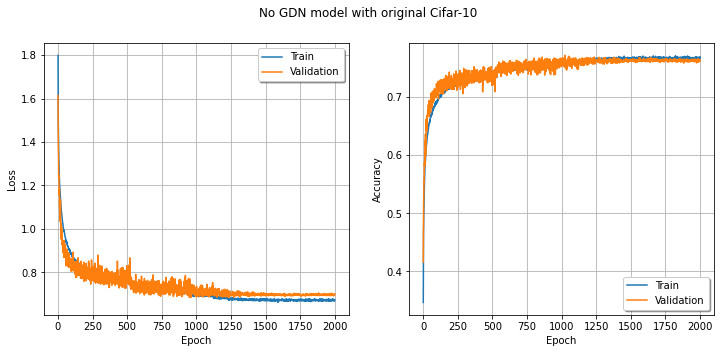

1 GDN


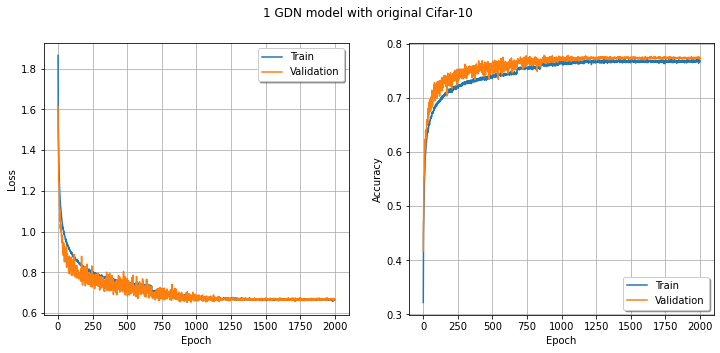

3 GDN


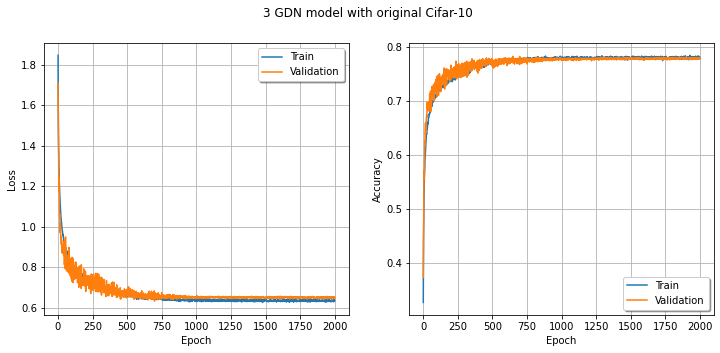

In [3]:
# Plot the training histories to check there was no overfitting
print('No GDN')
fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True,  figsize = (12,5))
ax1.plot(gdn_no_hist['loss'])
ax1.plot(gdn_no_hist['val_loss'])
ax1.grid()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(('Train', 'Validation'), loc = 'upper right', shadow = True)
ax2.plot(gdn_no_hist['accuracy'])
ax2.plot(gdn_no_hist['val_accuracy'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend(('Train', 'Validation'), loc = 'lower right', shadow = True)
fig.suptitle('No GDN model with original Cifar-10')
plt.show()

print('1 GDN')
fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True,  figsize = (12,5))
ax1.plot(gdn_1_hist['loss'])
ax1.plot(gdn_1_hist['val_loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend(('Train', 'Validation'), loc = 'upper right', shadow = True)
ax2.plot(gdn_1_hist['accuracy'])
ax2.plot(gdn_1_hist['val_accuracy'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend(('Train', 'Validation'), loc = 'lower right', shadow = True)
fig.suptitle('1 GDN model with original Cifar-10')
plt.show()

print('3 GDN')
fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True,  figsize = (12,5))
ax1.plot(gdn_3_hist['loss'])
ax1.plot(gdn_3_hist['val_loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend(('Train', 'Validation'), loc = 'upper right', shadow = True)
ax2.plot(gdn_3_hist['accuracy'])
ax2.plot(gdn_3_hist['val_accuracy'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend(('Train', 'Validation'), loc = 'lower right', shadow = True)
fig.suptitle('3 GDN model with original Cifar-10')
plt.show()

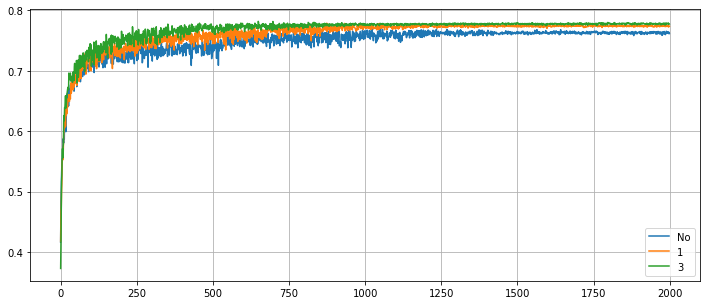

In [4]:
# PLot validation accuracy of the different models
fig, ax1 = plt.subplots(1, 1, sharex = True,  figsize = (12,5))
ax1.plot(gdn_no_hist['val_accuracy'], label = 'No')
ax1.plot(gdn_1_hist['val_accuracy'], label = '1')
ax1.plot(gdn_3_hist['val_accuracy'], label = '3')
ax1.grid()
plt.legend()
plt.show()

In [5]:
# Set the seed
seed = 123
random.seed(seed)

# Define modification functions
# Change luminance
def change_lum_smooth(image):
    return_image = image.copy()
    limit = random.uniform(2,4)
    vals = 0.1 + 1/(1 + np.exp(-np.linspace(-limit, limit, image.shape[0])))
    orientation = random.random()
    direction = random.random()
    if direction < 0.5:
        vals = np.array(list(vals)[::-1])
    if orientation < 0.5:
        for i in range(image.shape[2]):
            for j in range(image.shape[0]):
                return_image[:,j,i] = return_image[:,j,i]*vals
    if orientation >= 0.5:
        for i in range(image.shape[2]):
            for j in range(image.shape[0]):
                return_image[j,:,i] = return_image[j,:,i]*vals
    return tf.clip_by_value(return_image, 0, 255)

# Change contrast
def change_contrast_smooth(image):
    return_image = image.copy()
    limit = random.uniform(2,4)
    vals = 0.5 + 1/(1 + np.exp(-np.linspace(-limit, limit, image.shape[0])))
    orientation = random.random()
    direction = random.random()
    if direction < 0.5:
        vals = np.array(list(vals)[::-1])
    if orientation < 0.5:
        for i in range(image.shape[2]):
            for j in range(image.shape[0]):
                enhancer = ImageEnhance.Contrast(Image.fromarray(return_image[:,j,i]))
                return_image[:,j,i] = np.array(enhancer.enhance(vals[j])).reshape((32))
    if orientation >= 0.5:
        for i in range(image.shape[2]):
            for j in range(image.shape[0]):
                enhancer = ImageEnhance.Contrast(Image.fromarray(return_image[j,:,i]))
                return_image[j,:,i] = np.array(enhancer.enhance(vals[j])).reshape((32))
    return tf.clip_by_value(return_image, 0, 255)

# Change luminance, contrast or leave as original
def random_lum_contrast_smooth(image):
    random_val = random.random()
    if random_val < 1/3:
        return change_lum_smooth(image)
    elif random_val >= 1/3 and random_val < 2/3:
        return change_contrast_smooth(image)
    else:
        return image

In [6]:
# Load and split data
(X_train, Y_train), (X_test, Y_test) = datasets.cifar10.load_data()
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = seed)

# Made modifications to the data
X_test_contrast, X_test_lum, X_test_contrast_lum, X_test_lum_smooth, X_test_contrast_smooth, X_test_lum_contrast_smooth = [], [], [], [], [], []

for i in range(X_test.shape[0]):
    X_test_contrast.append(tf.image.stateless_random_contrast(X_test[i], lower = 0.2, upper = 1.8, seed = (seed, seed)))
    X_test_lum.append(X_test[i]*random.uniform(0.2,1))
    X_test_contrast_lum.append(tf.clip_by_value(tf.image.stateless_random_contrast(X_test[i]*random.uniform(0.2,1), lower = 0.2, upper = 1.8, seed = (seed, seed)), 0, 255))
    X_test_lum_smooth.append(change_lum_smooth(X_test[i]))
    X_test_contrast_smooth.append(change_contrast_smooth(X_test[i]))
    X_test_lum_contrast_smooth.append(random_lum_contrast_smooth(X_test[i]))

# Normalize data
X_test_contrast = np.array(X_test_contrast)/255.0
X_test_lum = np.array(X_test_lum)/255.0
X_test_contrast_lum = np.array(X_test_contrast_lum)/255.0
X_test_lum_smooth = np.array(X_test_lum_smooth)/255.0
X_test_contrast_smooth = np.array(X_test_contrast_smooth)/255.0
X_test_lum_contrast_smooth = np.array(X_test_lum_contrast_smooth)/255.0

# Check modified data shape
print(X_test_contrast.shape, X_test_lum.shape, X_test_contrast_lum.shape, X_test_lum_smooth.shape, X_test_contrast_smooth.shape, X_test_lum_contrast_smooth.shape)

X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

# One hot encoding to the labels
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
Y_test = to_categorical(Y_test)

# Check data shape
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

(10000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(45000, 32, 32, 3) (45000, 10) (5000, 32, 32, 3) (5000, 10) (10000, 32, 32, 3) (10000, 10)


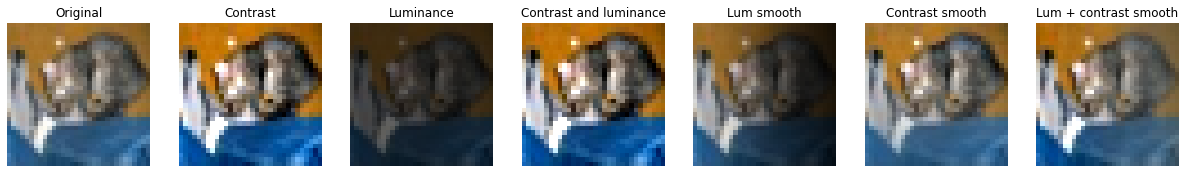

In [7]:
# Plot the modified data
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize = (21, 4))
ax1.imshow(X_test[0], vmin = 0, vmax = 1)
ax1.axis('off')
ax1.set_title('Original')
ax2.imshow(X_test_contrast[0], vmin = 0, vmax = 1)
ax2.axis('off')
ax2.set_title('Contrast')
ax3.imshow(X_test_lum[0], vmin = 0, vmax = 1)
ax3.axis('off')
ax3.set_title('Luminance')
ax4.imshow(X_test_contrast_lum[0], vmin = 0, vmax = 1)
ax4.axis('off')
ax4.set_title('Contrast and luminance')
ax5.imshow(X_test_lum_smooth[0], vmin = 0, vmax = 1)
ax5.axis('off')
ax5.set_title('Lum smooth')
ax6.imshow(X_test_contrast_smooth[0], vmin = 0, vmax = 1)
ax6.axis('off')
ax6.set_title('Contrast smooth')
ax7.imshow(X_test_lum_contrast_smooth[0], vmin = 0, vmax = 1)
ax7.axis('off')
ax7.set_title('Lum + contrast smooth')
plt.show()

In [9]:
# Build the different models (same as the trained models)
# Model with 3 GDN layers
print('Model with 3 GDN layers')
model_3_GDN = Sequential()
model_3_GDN.add(GDN(input_shape = X_train.shape[1:4], filter_shape = (7,7)))
model_3_GDN.add(Conv2D(8, 3, padding  = 'same', activation = 'relu'))
model_3_GDN.add(AveragePooling2D())
model_3_GDN.add(GDN(filter_shape = (5,5)))
model_3_GDN.add(Conv2D(16, 3, padding  = 'same', activation = 'relu'))
model_3_GDN.add(AveragePooling2D())
model_3_GDN.add(GDN(filter_shape = (3,3)))
model_3_GDN.add(Conv2D(32, 3, padding  = 'same', activation = 'relu'))
model_3_GDN.add(AveragePooling2D())
model_3_GDN.add(Flatten())
model_3_GDN.add(Dense(10))
model_3_GDN.add(Softmax())
model_3_GDN.summary()

# Model with 1 GDN layers
print('Model with 1 GDN layers')
model_1_GDN = Sequential()
model_1_GDN.add(GDN(input_shape = X_train.shape[1:4], filter_shape = (7,7)))
model_1_GDN.add(Conv2D(8, 3, padding  = 'same', activation = 'relu'))
model_1_GDN.add(AveragePooling2D())
model_1_GDN.add(Conv2D(16, 3, padding  = 'same', activation = 'relu'))
model_1_GDN.add(AveragePooling2D())
model_1_GDN.add(Conv2D(32, 3, padding  = 'same', activation = 'relu'))
model_1_GDN.add(AveragePooling2D())
model_1_GDN.add(Flatten())
model_1_GDN.add(Dense(10))
model_1_GDN.add(Softmax())
model_1_GDN.summary()

# Model with NO GDN layers
print('Model with no GDN layers')
model_no_GDN = Sequential()
model_no_GDN.add(Conv2D(8, 3, padding  = 'same', activation = 'relu', input_shape = X_train.shape[1:4]))
model_no_GDN.add(AveragePooling2D())
model_no_GDN.add(Conv2D(16, 3, padding  = 'same', activation = 'relu'))
model_no_GDN.add(AveragePooling2D())
model_no_GDN.add(Conv2D(32, 3, padding  = 'same', activation = 'relu'))
model_no_GDN.add(AveragePooling2D())
model_no_GDN.add(Flatten())
model_no_GDN.add(Dense(10))
model_no_GDN.add(Softmax())
model_no_GDN.summary()         

model_3_GDN.compile(loss = 'categorical_crossentropy', 
                    optimizer = 'adam', 
                    metrics = ['accuracy'])
model_1_GDN.compile(loss = 'categorical_crossentropy', 
                    optimizer = 'adam', 
                    metrics = ['accuracy'])
model_no_GDN.compile(loss = 'categorical_crossentropy', 
                     optimizer = 'adam', 
                     metrics = ['accuracy'])

Model with 3 GDN layers
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gdn (GDN)                    (None, 32, 32, 3)         450       
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 8)         0         
_________________________________________________________________
gdn_1 (GDN)                  (None, 16, 16, 8)         1624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 8, 16)          0         
_________________________________________________________________
gdn_2 (GDN)                  (No

In [10]:
# Load the best saved weights
print('3 GDN')
model_3_GDN.load_weights('./Classification/3_gdn.hdf5')

# Evaludate the model with all the data modifications
print(model_3_GDN.evaluate(X_test, Y_test))
print(model_3_GDN.evaluate(X_test_contrast, Y_test))
print(model_3_GDN.evaluate(X_test_lum, Y_test))
print(model_3_GDN.evaluate(X_test_contrast_lum, Y_test))
print(model_3_GDN.evaluate(X_test_lum_smooth, Y_test))
print(model_3_GDN.evaluate(X_test_contrast_smooth, Y_test))
print(model_3_GDN.evaluate(X_test_lum_contrast_smooth, Y_test))

3 GDN
313/313 [==============================] - 11s 4ms/step - loss: 0.6594 - accuracy: 0.7798
[0.6593700051307678, 0.7797999978065491]
313/313 [==============================] - 1s 4ms/step - loss: 0.8202 - accuracy: 0.7350
[0.8202084898948669, 0.7350000143051147]
313/313 [==============================] - 1s 4ms/step - loss: 0.8288 - accuracy: 0.7110
[0.8288462162017822, 0.7110000252723694]
313/313 [==============================] - 1s 4ms/step - loss: 0.8274 - accuracy: 0.7213
[0.8274002075195312, 0.7213000059127808]
313/313 [==============================] - 1s 4ms/step - loss: 0.8995 - accuracy: 0.6916
[0.8994642496109009, 0.6916000247001648]
313/313 [==============================] - 2s 5ms/step - loss: 0.6889 - accuracy: 0.7650
[0.6889196038246155, 0.7649999856948853]
313/313 [==============================] - 1s 4ms/step - loss: 0.7469 - accuracy: 0.7512
[0.7468673586845398, 0.7512000203132629]


In [11]:
# Load the best saved weights
print('1 GDN')
model_1_GDN.load_weights('./Classification/1_gdn.hdf5')

# Evaludate the model with all the data modifications
print(model_1_GDN.evaluate(X_test, Y_test))
print(model_1_GDN.evaluate(X_test_contrast, Y_test))
print(model_1_GDN.evaluate(X_test_lum, Y_test))
print(model_1_GDN.evaluate(X_test_contrast_lum, Y_test))
print(model_1_GDN.evaluate(X_test_lum_smooth, Y_test))
print(model_1_GDN.evaluate(X_test_contrast_smooth, Y_test))
print(model_1_GDN.evaluate(X_test_lum_contrast_smooth, Y_test))

1 GDN
313/313 [==============================] - 1s 3ms/step - loss: 0.6981 - accuracy: 0.7664
[0.6981279850006104, 0.7663999795913696]
313/313 [==============================] - 1s 4ms/step - loss: 0.9742 - accuracy: 0.7059
[0.9741971492767334, 0.7059000134468079]
313/313 [==============================] - 1s 4ms/step - loss: 0.8648 - accuracy: 0.7013
[0.8647910356521606, 0.7013000249862671]
313/313 [==============================] - 1s 4ms/step - loss: 0.9316 - accuracy: 0.6977
[0.9315630793571472, 0.697700023651123]
313/313 [==============================] - 1s 4ms/step - loss: 0.9756 - accuracy: 0.6665
[0.975635826587677, 0.6664999723434448]
313/313 [==============================] - 1s 4ms/step - loss: 0.7565 - accuracy: 0.7487
[0.7565426826477051, 0.7487000226974487]
313/313 [==============================] - 1s 4ms/step - loss: 0.8090 - accuracy: 0.7283
[0.8089933395385742, 0.7282999753952026]


In [12]:
# Load the best saved weights
print('No GDN')
model_no_GDN.load_weights('./Classification/No_gdn.hdf5')

# Evaludate the model with all the data modifications
print(model_no_GDN.evaluate(X_test, Y_test))
print(model_no_GDN.evaluate(X_test_contrast, Y_test))
print(model_no_GDN.evaluate(X_test_lum, Y_test))
print(model_no_GDN.evaluate(X_test_contrast_lum, Y_test))
print(model_no_GDN.evaluate(X_test_lum_smooth, Y_test))
print(model_no_GDN.evaluate(X_test_contrast_smooth, Y_test))
print(model_no_GDN.evaluate(X_test_lum_contrast_smooth, Y_test))

No GDN
313/313 [==============================] - 1s 3ms/step - loss: 0.7000 - accuracy: 0.7594
[0.7000086307525635, 0.7594000101089478]
313/313 [==============================] - 1s 3ms/step - loss: 0.9540 - accuracy: 0.7072
[0.9539501070976257, 0.7071999907493591]
313/313 [==============================] - 1s 3ms/step - loss: 0.9145 - accuracy: 0.6873
[0.9144912362098694, 0.6873000264167786]
313/313 [==============================] - 1s 3ms/step - loss: 0.8727 - accuracy: 0.7077
[0.8727293014526367, 0.7077000141143799]
313/313 [==============================] - 1s 3ms/step - loss: 1.0923 - accuracy: 0.6315
[1.0923149585723877, 0.6315000057220459]
313/313 [==============================] - 1s 3ms/step - loss: 0.7581 - accuracy: 0.7467
[0.7580980062484741, 0.7466999888420105]
313/313 [==============================] - 1s 4ms/step - loss: 0.8445 - accuracy: 0.7092
[0.8445168733596802, 0.7092000246047974]
